In [1]:
import pandas as pd
import numpy as np
from scipy.stats import fisher_exact
from scipy import stats
from statsmodels.stats.multitest import multipletests
from statsmodels.stats import multitest
import seaborn as sns
import pyBigWig
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [2]:
def read_stat_df(path):
    """read stat file
    """
    df = pd.read_table(path, header=None, names=['rid',
                                                 'pro',
                                                 'count'])
    
    return df

In [3]:
def per_rat(stat_df):
    """compute means of reads enh rat
    """
    
    group = stat_df.groupby('pro')
    stat_df_dict = {}
    for pro, gdf in group:
        stat_df_dict[pro] = gdf
    result_dict = {}
    for pro, df in stat_df_dict.items():
        result_dict[pro] = sum(df['count']) / len(df)
        
    pro_count = pd.DataFrame.from_dict(result_dict, orient='index')
    return pro_count, stat_df_dict

In [4]:
def ME_df(stat_dict, flag):
    """count ME, SE, NE
    """
    ME_dict = {}
    for pro, df in stat_dict.items():
        ME_count = len(df.loc[df['count']>=2])
        SE_count = len(df.loc[df['count']==1])
        NE_count = len(df.loc[df['count']==0])
        E_count = sum(df['count'])
        df_all = len(df)

        ME_ratio_list = []
        ME_ratio_list.append(ME_count)
        ME_ratio_list.append(SE_count)
        ME_ratio_list.append(NE_count)
        ME_ratio_list.append(ME_count/df_all)
        ME_ratio_list.append(SE_count/df_all)
        ME_ratio_list.append(NE_count/df_all)
        ME_ratio_list.append(E_count)
        ME_ratio_list.append(df_all)
        ME_dict[pro] = ME_ratio_list
        
    ME_df = pd.DataFrame.from_dict(ME_dict, orient='index')
    ME_df.reset_index(inplace=True)
    ME_df = ME_df.rename(columns={0: f'{flag}_ME', 1: f'{flag}_SE', 2: f'{flag}_NE',
                                  3: f'{flag}_ME_rat', 4: f'{flag}_SE_rat', 5: f'{flag}_NE_rat',
                                  6: f'{flag}_Ecount', 7: f'{flag}_reads',
                                  'index': f'{flag}_gene'})
    
    return ME_df

In [5]:
G_path = "~/G_stat_20k.txt"
K_path = "~/K_stat_20k.txt"

G_stat_df = read_stat_df(G_path)
K_stat_df = read_stat_df(K_path)

G_pro_df, G_dict = per_rat(G_stat_df)
K_pro_df, K_dict = per_rat(K_stat_df)

G_pro_df.columns=['enh_rat']
K_pro_df.columns=['enh_rat']

In [11]:
G_dict['SLC5A6']['count'].value_counts()

0    1310
1      78
Name: count, dtype: int64

In [6]:
len(G_stat_df['pro'].unique())

22204

In [7]:
K_stat_df.head()

,rid,pro,count
0,R10002_k3h,BRIP1,0
1,R10006_k3h,SLFNL1-AS1,0
2,R10006_k3h,CTPS1,0
3,R10006_k3h,ALDH4A1,0
4,R10008_k3h,PLA2G5,0


In [29]:
G_pivot_df.loc[G_pivot_df['G_gene']=='AGBL5']

,G_gene,G_ME,G_SE,G_NE,G_ME_rat,G_SE_rat,G_NE_rat,G_Ecount,G_reads
474,AGBL5,21,214,1047,0.016381,0.166927,0.816693,256,1282


In [13]:
G_pivot_df = ME_df(G_dict, 'G')

In [10]:
RNAseqfile = "~/GM12878_K562_TPM.csv"
RNAdf = pd.read_csv(RNAseqfile, sep="\t", header=0, index_col=0)
RNAdf.index = RNAdf.index.str.split(".").str[0] # ENSGID
RNAdf["G_RNAval"] =  RNAdf.loc[:, ["GM12878_A1", "GM12878_A2","GM12878_B1","GM12878_B2"] ].mean(axis=1).values
RNAdf["K_RNAval"] =  RNAdf.loc[:, ["K562_A1", "K562_A2","K562_B1","K562_B2"] ].mean(axis=1).values
RNAdf = RNAdf.reset_index()
RNA_df = RNAdf.drop_duplicates(subset='gene_id')

In [13]:
def diff_gene_read(path):
    """read up or down gene df"""
    df = pd.read_csv(path, sep="\t")
    
    return df

In [14]:
up_path = "~/Up_gene.txt"
down_path = "~/Down_gene.txt"
up_df = diff_gene_read(up_path)
up_df = up_df.reset_index()
down_df = diff_gene_read(down_path)
down_df = down_df.reset_index()
# hmexp_df = diff_gene_read(hmexp_path)
# hmexp_df = hmexp_df.reset_index()
up_df['tag'] = 'up'
down_df['tag'] = 'down'
up_df = up_df[['index', 'tag']]
down_df = down_df[['index', 'tag']]
diff_tag_df = pd.concat([up_df, down_df])
print(len(up_df) + len(down_df))

581


In [16]:
G_ME_df_ME = G_pivot_df[['G_gene', 'G_ME_rat', 'G_SE_rat']].copy()
K_ME_df_ME = K_pivot_df[['K_gene', 'K_ME_rat', 'K_SE_rat']].copy()

In [20]:
GM_diff_ME = pd.merge(G_ME_df_ME, diff_tag_df,
                      left_on='G_gene', right_on='index')
K_diff_ME = pd.merge(K_ME_df_ME, diff_tag_df,
                      left_on='K_gene', right_on='index')
use_col = ['G_gene', 'G_ME_rat', 'G_SE_rat', 'K_ME_rat', 'K_SE_rat', 'tag_y']
diff_ME_pivot = pd.merge(GM_diff_ME, K_diff_ME,
                         left_on='G_gene', right_on='K_gene')[use_col]

In [21]:
diff_ME_pivot = diff_ME_pivot.rename(columns={'G_gene': 'gene', 'tag_y': 'G_type'})

GTF_df = pd.read_table("~/GRch38_GENCODE_V29_merge_annotations_gtf.ENCFF159KBI.gtf",
                       header=None)

chr_list = ["chr1", "chr2", "chr3", "chr4", "chr5", "chr6",
            "chr7", "chr8", "chr9", "chr10", "chr11", "chr12",
            "chr13", "chr14", "chr15", "chr16", "chr17", "chr18",
            "chr19", "chr20", "chr21", "chr22", "chrX", "chrY"]
GTF_df = GTF_df.loc[GTF_df[0].isin(chr_list)]
GTF_df = GTF_df.loc[GTF_df[2] == 'gene']
GTF_df[9] = GTF_df[8].str.split('"', expand=True)[5]
id_name_trans = GTF_df[8].str.split('"', expand=True)[[1,5]]
id_name_trans[0] = id_name_trans[1].str.split('.', expand=True)[0]
id_name_trans = id_name_trans[[0,5]]
id_name_trans.columns=['id', 'name']

In [22]:
id_name_trans = id_name_trans.drop_duplicates(subset='id')

In [24]:
RNA_df = pd.merge(RNA_df, id_name_trans,
                 left_on='gene_id', right_on='id').drop('id', axis=1)

In [26]:
RNAdf = RNA_df[['name', 'G_RNAval', 'K_RNAval']]
RNAdf = RNAdf.drop_duplicates(subset=['name'])

In [27]:
ME_express_df = pd.merge(diff_ME_pivot, RNAdf,
                         left_on='gene', right_on='name')

In [31]:
def diff_df(ME_express_df):
    barG_up_df = ME_express_df.loc[ME_express_df['G_type']=='up', ['G_ME_rat']]
    barG_up_df['tag'] = f'G_up_{len(barG_up_df)}'
    barK_down_df = ME_express_df.loc[ME_express_df['G_type']=='up', ['K_ME_rat']]
    barK_down_df['tag'] = f'K_down_{len(barK_down_df)}'
    barG_up_df.columns = ['value', 'tag']
    barK_down_df.columns = ['value', 'tag']
    G_UP_PLOT = pd.concat([barG_up_df, barK_down_df], axis=0)
    
    barG_down_df = ME_express_df.loc[ME_express_df['G_type']=='down', ['G_ME_rat']]
    barG_down_df['tag'] = f'G_down_{len(barG_down_df)}'
    barK_up_df = ME_express_df.loc[ME_express_df['G_type']=='down', ['K_ME_rat']]
    barK_up_df['tag'] = f'K_up_{len(barK_up_df)}'
    barG_down_df.columns = ['value', 'tag']
    barK_up_df.columns = ['value', 'tag']
    G_DOWN_PLOT = pd.concat([barG_down_df, barK_up_df], axis=0)

    return G_UP_PLOT,G_DOWN_PLOT

In [33]:
G_UP_PLOT,G_DOWN_PLOT = diff_df(ME_express_df)

In [35]:
G_UP_PLOT = G_UP_PLOT .reset_index(drop=True)
G_DOWN_PLOT = G_DOWN_PLOT .reset_index(drop=True)

In [36]:
%load_ext rpy2.ipython

In [40]:
enh_rat_express = pd.merge(G_pro_df.reset_index(), K_pro_df.reset_index(),
                           on='index')
enh_rat_express.columns=['gene', 'G_enh_rat', 'K_enh_rat']
enh_rat_express = pd.merge(enh_rat_express, RNAdf,
                           left_on='gene', right_on='name').drop('name', axis=1)
enh_rat_express = pd.merge(enh_rat_express, G_pivot_df,
                           left_on='gene', right_on='G_gene').drop(['G_gene', 'G_ME', 'G_SE', 'G_NE',
                                                                    'G_Ecount', 'G_reads', 'G_NE_rat'], axis=1)
enh_rat_express = pd.merge(enh_rat_express, K_pivot_df,
                           left_on='gene', right_on='K_gene').drop(['K_gene', 'K_ME', 'K_SE', 'K_NE',
                                                                    'K_Ecount', 'K_reads', 'K_NE_rat'], axis=1)

In [41]:
enh_rat_express

,gene,G_enh_rat,K_enh_rat,G_RNAval,K_RNAval,G_ME_rat,G_SE_rat,K_ME_rat,K_SE_rat
0,A1BG,0.000000,0.000000,11.2575,1.9500,0.000000,0.000000,0.000000,0.000000
1,A1BG-AS1,0.000000,0.000000,3.7100,1.4275,0.000000,0.000000,0.000000,0.000000
2,A1CF,0.000000,0.000000,0.0000,0.0050,0.000000,0.000000,0.000000,0.000000
3,A2M,0.000000,0.000000,0.0300,0.0100,0.000000,0.000000,0.000000,0.000000
4,A2M-AS1,0.000000,0.000000,0.0700,0.0075,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
22199,ZXDC,0.249795,0.186207,8.6325,3.2600,0.018837,0.212121,0.005517,0.175172
22200,ZYG11A,0.035064,0.263011,2.6825,7.6600,0.000674,0.033715,0.034135,0.194180
22201,ZYG11B,0.069767,0.149387,4.6425,8.8700,0.002982,0.063804,0.016965,0.115457
22202,ZYX,0.015385,0.000000,16.8100,5.8375,0.000000,0.015385,0.000000,0.000000


In [42]:
GTF_df[10] = GTF_df[8].str.split('"', expand=True)[3]
proteincod_genes =GTF_df.loc[GTF_df[10]=='protein_coding'][9].unique()

In [43]:
enh_rat_express = enh_rat_express.loc[enh_rat_express['gene'].isin(proteincod_genes)].copy()

In [44]:
enh_rat_express['G_express_type']=0
enh_rat_express['K_express_type']=0

In [45]:
def rank(df, q_col, type_col):
    Q1 = df.loc[df[q_col]>0, q_col].quantile(0.8)
    Q2 = df.loc[df[q_col]>0, q_col].quantile(0.6)
    df.loc[df[q_col]>=Q1, type_col] = f'high\n{len(df.loc[df[q_col]>=Q1])}'
    df.loc[(df[q_col]<Q1) & (df[q_col]>=Q2), type_col] = f'mid\n{len(df.loc[(df[q_col]<Q1) & (df[q_col]>=Q2)])}'
    df.loc[(df[q_col]<Q2) & (df[q_col]>0), type_col] = f'low\n{len(df.loc[(df[q_col]<Q2) & (df[q_col]>0)])}'
    df.loc[df[q_col]==0, type_col] = f'None\n{len(df.loc[df[q_col]==0])}'
    return df

In [46]:
enh_rat_express = rank(enh_rat_express, 'G_RNAval', 'G_express_type')
enh_rat_express = rank(enh_rat_express, 'K_RNAval', 'K_express_type')

In [47]:
enh_rat_express.head()

,gene,G_enh_rat,K_enh_rat,G_RNAval,K_RNAval,G_ME_rat,G_SE_rat,K_ME_rat,K_SE_rat,G_express_type,K_express_type
0,A1BG,0.0,0.0,11.2575,1.950,0.0,0.0,0.0,0.0,low\n9555,low\n9192
2,A1CF,0.0,0.0,0.0000,0.005,0.0,0.0,0.0,0.0,None\n2799,low\n9192
3,A2M,0.0,0.0,0.0300,0.010,0.0,0.0,0.0,0.0,low\n9555,low\n9192
5,A2ML1,0.0,0.0,0.0000,0.035,0.0,0.0,0.0,0.0,None\n2799,low\n9192
7,A3GALT2,0.0,0.0,0.0000,0.000,0.0,0.0,0.0,0.0,None\n2799,None\n3404


In [48]:
gene_pos = GTF_df[[0,3,4,6,9]].copy()
gene_pos.columns=['chr', 'start', 'end', 'strand', 'name']
gene_pos = gene_pos.drop_duplicates(subset='name')
target_gene_list = enh_rat_express['gene'].tolist()
gene_pos = gene_pos.loc[gene_pos['name'].isin(target_gene_list)]

In [49]:
# 定义调整函数
def adjust_positions(row):
    if row['strand'] == '+':
        return row['start'] - 1000, row['start'] + 1000
    else:  # strand is '-'
        return row['end'] - 1000, row['end'] + 1000



In [50]:
# 应用调整函数到数据框
gene_pos[['start', 'end']] = gene_pos.apply(adjust_positions, axis=1, result_type='expand')

In [51]:
gene_pos

,chr,start,end,strand,name
57,chr1,64419,66419,+,OR4F5
315,chr1,450697,452697,-,OR4F29
443,chr1,685673,687673,-,OR4F16
714,chr1,922928,924928,+,SAMD11
1071,chr1,958309,960309,-,NOC2L
...,...,...,...,...,...
2732448,chrX,155457672,155459672,-,F8A3
2732459,chrX,155459005,155461005,-,H2AFB3
2732480,chrX,155668944,155670944,-,TMLHE
2732533,chrX,155766812,155768812,+,SPRY3


In [52]:
def Bwmean(regions, bw):
    '''
    get mean values for regions from a bigwig file
    '''
    means = []
    chrom_lengths =  bw.chroms()
    for i, r in regions.iterrows() :
        chrom, start, end = r["chr"], r["start"], r["end"]
        if end >= chrom_lengths[chrom]:
            end = chrom_lengths[chrom]
        mv = bw.stats(chrom, start, end, 'mean')[0]
        means.append(mv)
    return(means)

In [53]:
# bigwig file path
bigdir = "~/process"

# Open bigWig file
G_GpC_bw = pyBigWig.open(f"{bigdir}/GM12878_Integrated_GpC.bigWig") 
K_GpC_bw = pyBigWig.open(f"{bigdir}/K562_Integrated_GpC.bigWig") 
G_CpG_bw = pyBigWig.open(f"{bigdir}/GM12878_Integrated_CpG.bigWig")
K_CpG_bw = pyBigWig.open(f"{bigdir}/K562_Integrated_CpG.bigWig")
WGBS_bw = pyBigWig.open(f"{bigdir}/K562_WGBS_ENCFF660IHA_filterchr.bigWig")

In [54]:
gene_pos['G_GCmean'] = Bwmean(gene_pos, G_GpC_bw)
gene_pos['K_GCmean'] = Bwmean(gene_pos, K_GpC_bw)
gene_pos['G_CGmean'] = Bwmean(gene_pos, G_CpG_bw)
gene_pos['K_CGmean'] = Bwmean(gene_pos, K_CpG_bw)

gene_pos['WGBS'] = Bwmean(gene_pos, WGBS_bw)

In [55]:
gene_pos.head()

,chr,start,end,strand,name,G_GCmean,K_GCmean,G_CGmean,K_CGmean,WGBS
57,chr1,64419,66419,+,OR4F5,0.192252,0.169206,0.431503,0.541128,1.000000
315,chr1,450697,452697,-,OR4F29,0.105726,0.376144,0.359916,0.247587,NaN
443,chr1,685673,687673,-,OR4F16,0.167226,0.309852,0.409000,0.289049,1.000000
714,chr1,922928,924928,+,SAMD11,0.074747,0.175521,0.042516,0.041800,0.034118
1071,chr1,958309,960309,-,NOC2L,0.231217,0.267385,0.191656,0.173964,0.201492


In [56]:
PIVOT_DF = pd.merge(enh_rat_express, gene_pos,
                    left_on='gene', right_on='name').drop('name', axis=1)

In [57]:
PIVOT_DF['WGBS'].max()

1.0

R[write to console]: Loading required package: ggplot2

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




Saving 6.67 x 6.67 in image


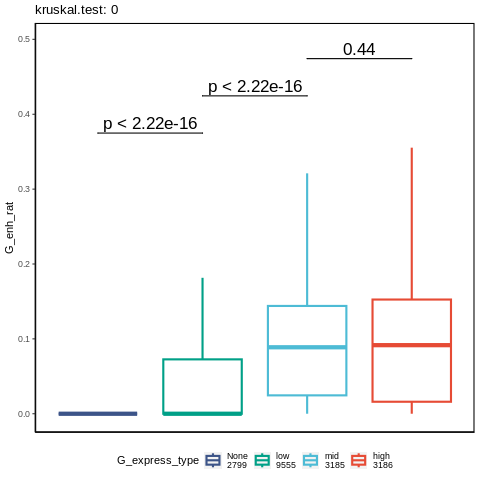

In [62]:
%%R -i enh_rat_express
library(ggpubr)
library(dplyr)
library(ggplot2)
library(ggsci)
enh_rat_express$G_express_type <- factor(enh_rat_express$G_express_type,levels = c("None\n2799", "low\n9555", "mid\n3185", "high\n3186"))
result_kw <- kruskal.test(G_enh_rat ~ G_express_type, data = enh_rat_express)
p <- ggplot(enh_rat_express, aes(x = G_express_type, y = G_enh_rat,  fill = G_express_type)) +   
  geom_boxplot(aes(color=G_express_type), outlier.shape = NA, linewidth=1, fill=NA) +
  labs(x = "G_express_type", y = "G_enh_rat") +
  theme(panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          axis.text.x = element_blank(),
          axis.ticks.x = element_blank(),
          axis.title.x = element_blank(),
          panel.background = element_blank(), 
          panel.border = element_rect(colour = "black", fill=NA, size=1),
          axis.line = element_line(),
          legend.position = "bottom")+
  labs(title = sprintf("kruskal.test: %s", result_kw[3])) +
  geom_signif(comparisons = list(c("low\n9555","None\n2799"),c("mid\n3185","low\n9555"),c("high\n3186","mid\n3185")), map_signif_level = F, 
              test = t.test,step_increase = 0.1, textsize = 6, color = "black",
              y_position=0.35, tip_length=0) +
  # scale_colour_manual(values =  c("#00A087FF", "#4DBBD5FF", "#E64B35FF", "")) 
  # scale_fill_manual(values=c("None\n2799"="#3C5488FF", "low\n9555"="#00A087FF", "mid\n3185"="#4DBBD5FF", "high\n3186" ="#E64B35FF")) +
  scale_color_manual(values=c("None\n2799"="#3C5488FF", "low\n9555"="#00A087FF", "mid\n3185"="#4DBBD5FF", "high\n3186" ="#E64B35FF"))
p

Saving 6.67 x 6.67 in image


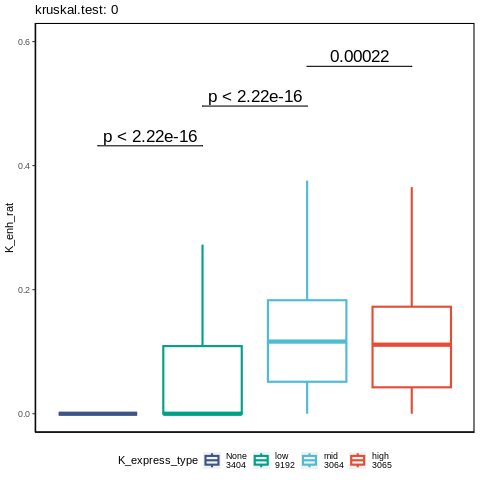

In [63]:
%%R -i enh_rat_express
enh_rat_express$K_express_type <- factor(enh_rat_express$K_express_type,levels = c("None\n3404", "low\n9192", "mid\n3064", "high\n3065"))
result_kw <- kruskal.test(K_enh_rat ~ K_express_type, data = enh_rat_express)
p <- ggplot(enh_rat_express, aes(x = K_express_type, y = K_enh_rat,  fill = K_express_type)) +   
  geom_boxplot(aes(color=K_express_type), outlier.shape = NA, linewidth=1, fill=NA) +
  labs(x = "K_express_type", y = "K_enh_rat") +
  theme(panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          axis.text.x = element_blank(),
          axis.ticks.x = element_blank(),
          axis.title.x = element_blank(),
          panel.background = element_blank(), 
          panel.border = element_rect(colour = "black", fill=NA, size=1),
          axis.line = element_line(),
          legend.position = "bottom")+
  labs(title = sprintf("kruskal.test: %s", result_kw[3])) +
  geom_signif(comparisons = list(c("low\n9192","None\n3404"),c("mid\n3064","low\n9192"),c("high\n3065","mid\n3064")), map_signif_level = F, 
              test = t.test,step_increase = 0.1, textsize = 6, color = "black",
              y_position=0.4, tip_length=0) +
  scale_fill_manual(values=c("None\n3404"="#3C5488FF", "low\n9192"="#00A087FF", "mid\n3064"="#4DBBD5FF", "high\n3065" ="#E64B35FF")) +
  scale_color_manual(values=c("None\n3404"="#3C5488FF", "low\n9192"="#00A087FF", "mid\n3064"="#4DBBD5FF", "high\n3065" ="#E64B35FF")) +
  coord_cartesian(ylim = c(0, 0.6))
p

Saving 6.67 x 6.67 in image


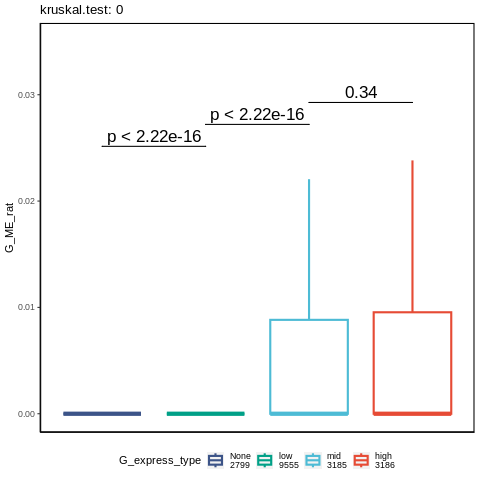

In [64]:
%%R -i enh_rat_express
enh_rat_express$G_express_type <- factor(enh_rat_express$G_express_type,levels = c("None\n2799", "low\n9555", "mid\n3185", "high\n3186"))
result_kw <- kruskal.test(G_ME_rat ~ G_express_type, data = enh_rat_express)
p <- ggplot(enh_rat_express, aes(x = G_express_type, y = G_ME_rat,  fill = G_express_type)) +   
  geom_boxplot(aes(color=G_express_type), fill=NA, outlier.shape = NA, linewidth=1) +
  labs(x = "G_express_type", y = "G_ME_rat") +
  theme(panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          axis.text.x = element_blank(),
          axis.ticks.x = element_blank(),
          axis.title.x = element_blank(),
          panel.background = element_blank(), 
          panel.border = element_rect(colour = "black", fill=NA, size=1),
          axis.line = element_line(),
          legend.position = "bottom")+
  labs(title = sprintf("kruskal.test: %s", result_kw[3])) +
  geom_signif(
      comparisons = list(c("low\n9555","None\n2799"),c("mid\n3185","low\n9555"),c("high\n3186","mid\n3185")), map_signif_level = F, 
      test = t.test,step_increase = 0.02, textsize = 6, color = "black", 
      y_position=0.02, tip_length=0) +
  scale_fill_manual(values=c("None\n2799"="#3C5488FF", "low\n9555"="#00A087FF", "mid\n3185"="#4DBBD5FF", "high\n3186" ="#E64B35FF")) +
  scale_color_manual(values=c("None\n2799"="#3C5488FF", "low\n9555"="#00A087FF", "mid\n3185"="#4DBBD5FF", "high\n3186" ="#E64B35FF")) +
  coord_cartesian(ylim = c(0, 0.035))
p

Saving 6.67 x 6.67 in image


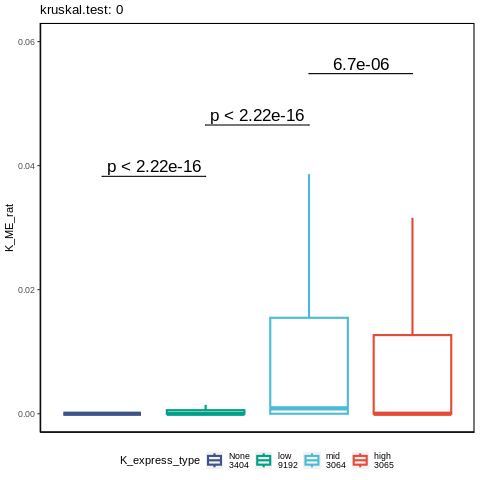

In [65]:
%%R -i enh_rat_express
enh_rat_express$K_express_type <- factor(enh_rat_express$K_express_type,levels = c("None\n3404", "low\n9192", "mid\n3064", "high\n3065"))
result_kw <- kruskal.test(K_ME_rat ~ K_express_type, data = enh_rat_express)
p <- ggplot(enh_rat_express, aes(x = K_express_type, y = K_ME_rat,  fill = K_express_type)) +   
  geom_boxplot(aes(color=K_express_type), outlier.shape = NA, linewidth=1, fill=NA) +
  labs(x = "K_express_type", y = "K_ME_rat") +
  theme(panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          axis.text.x = element_blank(),
          axis.ticks.x = element_blank(),
          axis.title.x = element_blank(),
          panel.background = element_blank(), 
          panel.border = element_rect(colour = "black", fill=NA, size=1),
          axis.line = element_line(),
          legend.position = "bottom")+
  labs(title = sprintf("kruskal.test: %s", result_kw[3])) +
  geom_signif(comparisons = list(c("low\n9192","None\n3404"),c("mid\n3064","low\n9192"),c("high\n3065","mid\n3064")), map_signif_level = F, 
              test = t.test,step_increase = 0.05, textsize = 6, color = "black",
              y_position=0.03, tip_length=0) +
  scale_fill_manual(values=c("None\n3404"="#3C5488FF", "low\n9192"="#00A087FF", "mid\n3064"="#4DBBD5FF", "high\n3065" ="#E64B35FF")) +
  scale_color_manual(values=c("None\n3404"="#3C5488FF", "low\n9192"="#00A087FF", "mid\n3064"="#4DBBD5FF", "high\n3065" ="#E64B35FF")) +
  coord_cartesian(ylim = c(0, 0.06))
p

Saving 6.67 x 6.67 in image


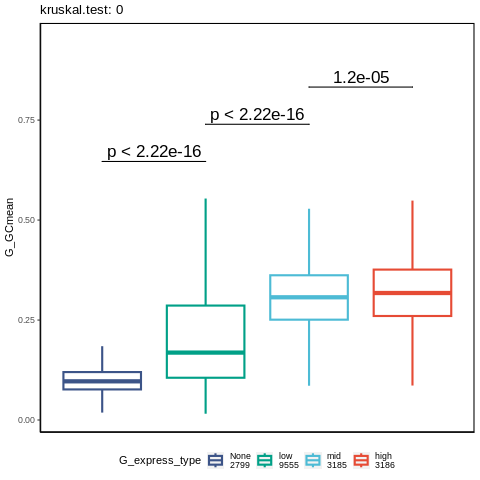

In [66]:
%%R -i PIVOT_DF
PIVOT_DF$G_express_type <- factor(PIVOT_DF$G_express_type,levels = c("None\n2799", "low\n9555", "mid\n3185", "high\n3186"))
result_kw <- kruskal.test(G_GCmean ~ G_express_type, data = PIVOT_DF)
p <- ggplot(PIVOT_DF, aes(x = G_express_type, y = G_GCmean,  fill = G_express_type)) +   
  geom_boxplot(aes(color=G_express_type), outlier.shape = NA, fill=NA, linewidth=1) +
  labs(x = "G_express_type", y = "G_GCmean") +
  theme(panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          axis.text.x = element_blank(),
          axis.ticks.x = element_blank(),
          axis.title.x = element_blank(),
          panel.background = element_blank(), 
          panel.border = element_rect(colour = "black", fill=NA, size=1),
          axis.line = element_line(),
          legend.position = "bottom")+
  labs(title = sprintf("kruskal.test: %s", result_kw[3])) +
  geom_signif(
      comparisons = list(c("low\n9555","None\n2799"),c("mid\n3185","low\n9555"),c("high\n3186","mid\n3185")), map_signif_level = F, 
      test = t.test,step_increase = 0.1, textsize = 6, color = "black",
      y_position=0.6, tip_length=0) +
  scale_fill_manual(values=c("None\n2799"="#3C5488FF", "low\n9555"="#00A087FF", "mid\n3185"="#4DBBD5FF", "high\n3186" ="#E64B35FF")) +
  scale_color_manual(values=c("None\n2799"="#3C5488FF", "low\n9555"="#00A087FF", "mid\n3185"="#4DBBD5FF", "high\n3186" ="#E64B35FF"))
p

Saving 6.67 x 6.67 in image


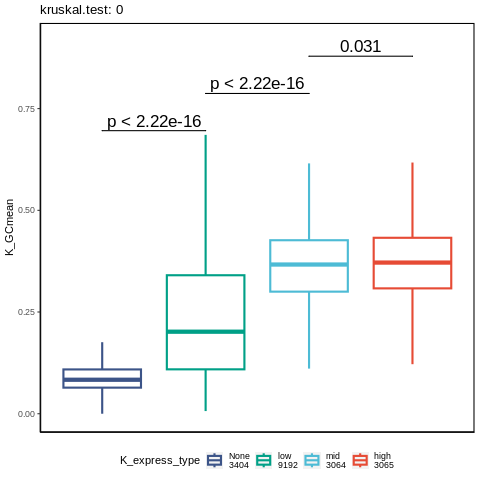

In [67]:
%%R -i PIVOT_DF
PIVOT_DF$K_express_type <- factor(PIVOT_DF$K_express_type,levels = c("None\n3404", "low\n9192", "mid\n3064", "high\n3065"))
result_kw <- kruskal.test(K_GCmean ~ K_express_type, data = PIVOT_DF)
p <- ggplot(PIVOT_DF, aes(x = K_express_type, y = K_GCmean,  fill = K_express_type)) +   
  geom_boxplot(aes(color=K_express_type),, outlier.shape = NA, fill=NA, linewidth=1) +
  labs(x = "K_express_type", y = "K_GCmean") +
  theme(panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          axis.text.x = element_blank(),
          axis.ticks.x = element_blank(),
          axis.title.x = element_blank(),
          panel.background = element_blank(), 
          panel.border = element_rect(colour = "black", fill=NA, size=1),
          axis.line = element_line(),
          legend.position = "bottom")+
  labs(title = sprintf("kruskal.test: %s", result_kw[3])) +
  geom_signif(comparisons = list(c("low\n9192","None\n3404"),c("mid\n3064","low\n9192"),c("high\n3065","mid\n3064")), map_signif_level = F, 
              test = t.test,step_increase = 0.1, textsize = 6, color = "black",
              y_position=0.65, tip_length=0) +
  scale_fill_manual(values=c("None\n3404"="#3C5488FF", "low\n9192"="#00A087FF", "mid\n3064"="#4DBBD5FF", "high\n3065" ="#E64B35FF")) +
  scale_color_manual(values=c("None\n3404"="#3C5488FF", "low\n9192"="#00A087FF", "mid\n3064"="#4DBBD5FF", "high\n3065" ="#E64B35FF"))
p

Saving 6.67 x 6.67 in image


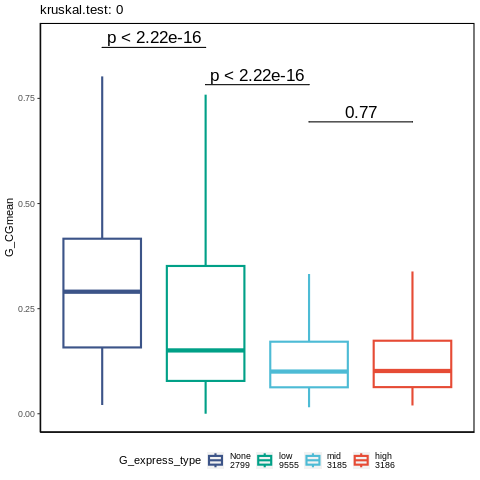

In [68]:
%%R -i PIVOT_DF
PIVOT_DF$G_express_type <- factor(PIVOT_DF$G_express_type,levels = c("None\n2799", "low\n9555", "mid\n3185", "high\n3186"))
result_kw <- kruskal.test(G_CGmean ~ G_express_type, data = PIVOT_DF)
p <- ggplot(PIVOT_DF, aes(x = G_express_type, y = G_CGmean,  fill = G_express_type)) +   
  geom_boxplot(aes(color=G_express_type), outlier.shape = NA, fill=NA, linewidth=1) +
  labs(x = "G_express_type", y = "G_CGmean") +
  theme(panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          axis.text.x = element_blank(),
          axis.ticks.x = element_blank(),
          axis.title.x = element_blank(),
          panel.background = element_blank(), 
          panel.border = element_rect(colour = "black", fill=NA, size=1),
          axis.line = element_line(),
          legend.position = "bottom")+
  labs(title = sprintf("kruskal.test: %s", result_kw[3])) +
  geom_signif(
      comparisons = list(c("high\n3186","mid\n3185"),c("mid\n3185","low\n9555"),c("low\n9555","None\n2799")), map_signif_level = F, 
      test = t.test,step_increase = 0.1, textsize = 6, color = "black",
      y_position=0.65, tip_length=0) +
  scale_fill_manual(values=c("None\n2799"="#3C5488FF", "low\n9555"="#00A087FF", "mid\n3185"="#4DBBD5FF", "high\n3186" ="#E64B35FF")) +
  scale_color_manual(values=c("None\n2799"="#3C5488FF", "low\n9555"="#00A087FF", "mid\n3185"="#4DBBD5FF", "high\n3186" ="#E64B35FF"))
p

Saving 6.67 x 6.67 in image


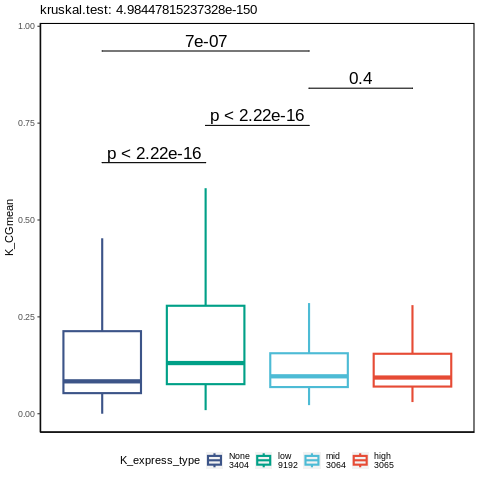

In [69]:
%%R -i PIVOT_DF
PIVOT_DF$K_express_type <- factor(PIVOT_DF$K_express_type,levels = c("None\n3404", "low\n9192", "mid\n3064", "high\n3065"))
result_kw <- kruskal.test(K_CGmean ~ K_express_type, data = PIVOT_DF)
p <- ggplot(PIVOT_DF, aes(x = K_express_type, y = K_CGmean,  fill = K_express_type)) +   
  geom_boxplot(aes(color=K_express_type), outlier.shape = NA, fill=NA, linewidth=1) +
  labs(x = "K_express_type", y = "K_CGmean") +
  theme(panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          axis.text.x = element_blank(),
          axis.ticks.x = element_blank(),
          axis.title.x = element_blank(),
          panel.background = element_blank(), 
          panel.border = element_rect(colour = "black", fill=NA, size=1),
          axis.line = element_line(),
          legend.position = "bottom")+
  labs(title = sprintf("kruskal.test: %s", result_kw[3])) +
  geom_signif(comparisons = list(c("low\n9192","None\n3404"),c("mid\n3064","low\n9192")
                                 ,c("high\n3065","mid\n3064"),c("None\n3404","mid\n3064")), map_signif_level = F, 
              test = t.test,step_increase = 0.1, textsize = 6, color = "black",
              y_position=0.6, tip_length=0) +
  scale_fill_manual(values=c("None\n3404"="#3C5488FF", "low\n9192"="#00A087FF", "mid\n3064"="#4DBBD5FF", "high\n3065" ="#E64B35FF")) +
  scale_color_manual(values=c("None\n3404"="#3C5488FF", "low\n9192"="#00A087FF", "mid\n3064"="#4DBBD5FF", "high\n3065" ="#E64B35FF"))
p

Saving 6.67 x 6.67 in image


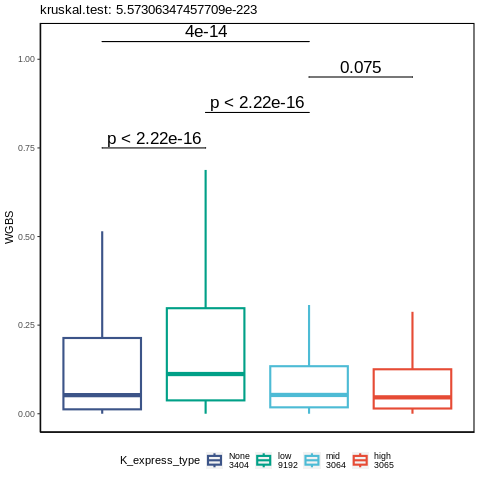

In [70]:
%%R -i PIVOT_DF
PIVOT_DF$K_express_type <- factor(PIVOT_DF$K_express_type,levels = c("None\n3404", "low\n9192", "mid\n3064", "high\n3065"))
result_kw <- kruskal.test(WGBS ~ K_express_type, data = PIVOT_DF)
p <- ggplot(PIVOT_DF, aes(x = K_express_type, y = WGBS,  fill = K_express_type)) +   
  geom_boxplot(aes(color=K_express_type), outlier.shape = NA, fill=NA, linewidth=1) +
  labs(x = "K_express_type", y = "WGBS") +
    theme(panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          axis.text.x = element_blank(),
          axis.ticks.x = element_blank(),
          axis.title.x = element_blank(),
          panel.background = element_blank(), 
          panel.border = element_rect(colour = "black", fill=NA, size=1),
          axis.line = element_line(),
          legend.position = "bottom")+
  labs(title = sprintf("kruskal.test: %s", result_kw[3])) +
  geom_signif(comparisons = list(c("low\n9192","None\n3404"),c("mid\n3064","low\n9192")
                                 ,c("high\n3065","mid\n3064"),c("None\n3404","mid\n3064")), map_signif_level = F, 
              test = t.test,step_increase = 0.1, textsize = 6, color = "black",
              y_position=0.7, tip_length=0) +
  scale_fill_manual(values=c("None\n3404"="#3C5488FF", "low\n9192"="#00A087FF", "mid\n3064"="#4DBBD5FF", "high\n3065" ="#E64B35FF")) +
  scale_color_manual(values=c("None\n3404"="#3C5488FF", "low\n9192"="#00A087FF", "mid\n3064"="#4DBBD5FF", "high\n3065" ="#E64B35FF"))
p

In [71]:
PIVOT_DF['G_log2'] = np.log2(PIVOT_DF['G_RNAval'] + 1)
PIVOT_DF['K_log2'] = np.log2(PIVOT_DF['K_RNAval'] + 1)

In [72]:
PIVOT_DF = PIVOT_DF.sort_values("G_log2")

In [75]:
def bin_df(file_path, namelist):
    """读取enh文件，并计算pos"""
    binfile_df = pd.read_csv(file_path, sep="\t", header=None,
                             names=name_list)
    binfile_df['pos'] = (binfile_df['start']+binfile_df['end']) / 2
    binfile_df = binfile_df.loc[binfile_df.chrom.isin(chr_list)]
    
    return binfile_df

def pro_enh_dict(bins_df):
    """Match pro to enh"""
    enh_name_len = len(bins_df)
    enh_name_list = [f"E{name_id}" for name_id in range(enh_name_len)]
    bins_df['Eid'] = enh_name_list
    
    bins_dict = {}
    bins_group = bins_df.groupby('targetgene')
    for target_gene, df in bins_group:
        keys = df['Eid']
        values = list(zip(df['chrom'] , df['start'], df['end']))
        eid_dict = {k: v for k, v in zip(keys, values)}
        bins_dict[target_gene] = eid_dict
    return bins_dict, bins_df

K_binfile = "~/K562.enh_38_sorted.txt"
G_binfile = "~/GM12878.enh_38_sorted.txt"
name_list = ['chrom', 'start', 'end', 'targetgene',
             'activity', 'hic_contact', 'ABC_Score']

K_binfile_df = bin_df(K_binfile, name_list)
G_binfile_df = bin_df(G_binfile, name_list)

K_pro_enh_dict, K_enh_total = pro_enh_dict(K_binfile_df.copy())
G_pro_enh_dict, G_enh_total = pro_enh_dict(G_binfile_df.copy())

Kenh_pro_df = pd.DataFrame()
for key, value in K_pro_enh_dict.items():
    tmp_df = pd.DataFrame.from_dict(value, orient='index')
    tmp_df[3] = key
    Kenh_pro_df = pd.concat([Kenh_pro_df, tmp_df])

Genh_pro_df = pd.DataFrame()
for key, value in G_pro_enh_dict.items():
    tmp_df = pd.DataFrame.from_dict(value, orient='index')
    tmp_df[3] = key
    Genh_pro_df = pd.concat([Genh_pro_df, tmp_df])

Genh_pro_df.columns = ['chr', 'start', 'end', 'targetgene']
Kenh_pro_df.columns = ['chr', 'start', 'end', 'targetgene']

Genh_pro_df['G_GCmean'] = Bwmean(Genh_pro_df, G_GpC_bw)
Kenh_pro_df['K_GCmean'] = Bwmean(Kenh_pro_df, K_GpC_bw)
Genh_pro_df['G_CGmean'] = Bwmean(Genh_pro_df, G_CpG_bw)
Kenh_pro_df['K_CGmean'] = Bwmean(Kenh_pro_df, K_CpG_bw)

G_pro_correnh_meandict = {}
K_pro_correnh_meandict = {}

tmp_group = Genh_pro_df.groupby('targetgene')

for gene, df in tmp_group:
    tmp_list = []
    tmp_list.append(df['G_GCmean'].mean())
    tmp_list.append(df['G_CGmean'].mean())
    G_pro_correnh_meandict[gene] = tmp_list

G_pro_correnh_meandf = pd.DataFrame.from_dict(G_pro_correnh_meandict, orient='index')

tmp_group = Kenh_pro_df.groupby('targetgene')

for gene, df in tmp_group:
    tmp_list = []
    tmp_list.append(df['K_GCmean'].mean())
    tmp_list.append(df['K_CGmean'].mean())
    K_pro_correnh_meandict[gene] = tmp_list

K_pro_correnh_meandf = pd.DataFrame.from_dict(K_pro_correnh_meandict, orient='index')

G_pro_correnh_meandf = G_pro_correnh_meandf.reset_index()
G_pro_correnh_meandf.columns = ['targetgene', 'G_enhGC', 'G_enhCG']

K_pro_correnh_meandf = K_pro_correnh_meandf.reset_index()
K_pro_correnh_meandf.columns = ['targetgene', 'K_enhGC', 'K_enhCG']

In [76]:
PIVOT_Enh_DF = pd.merge(PIVOT_DF, G_pro_correnh_meandf,
                        left_on='gene', right_on='targetgene',
                        how='left').drop('targetgene', axis=1)

PIVOT_Enh_DF = pd.merge(PIVOT_Enh_DF, K_pro_correnh_meandf,
                        left_on='gene', right_on='targetgene',
                        how='left').drop('targetgene', axis=1)

In [78]:
def min_max_normalize(data):
    min_val = min(data)
    max_val = max(data)
    normalized = [(x - min_val) / (max_val - min_val) for x in data]
    return normalized

# 示例数据
data = [1, 2, 3, 4, 5]

# 应用归一化
normalized_data = min_max_normalize(data)
print("归一化后的数据:", normalized_data)

归一化后的数据: [0.0, 0.25, 0.5, 0.75, 1.0]


In [80]:
Heatmap_data = PIVOT_Enh_DF[[
    'G_log2', 'K_log2', 'G_ME_rat', 'K_ME_rat',
    'G_GCmean', 'K_GCmean', 'G_CGmean', 'K_CGmean',
    'WGBS', 'G_enhGC', 'G_enhCG', 'K_enhGC', 'K_enhCG',
    'G_express_type', 'K_express_type',
]].copy()
normalized_col  =[
    'G_log2', 'K_log2'
]

In [81]:
%%R
library('ComplexHeatmap')
library('circlize')
library("RColorBrewer")
library("pheatmap")
library("ggplot2")
library(ggsignif)
library(ggsci)

R[write to console]: Loading required package: grid

R[write to console]: ========================================
ComplexHeatmap version 2.14.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))


R[write to console]: ========================================
circlize version 0.4.15
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circl

In [83]:
%%R -i PIVOT_DF
data <- subset(PIVOT_DF, select = G_log2)
data$x <- rownames(data)
data$y <- 1
head(data)

      G_log2     x y
1976       0  1976 1
12650      0 12650 1
2372       0  2372 1
12652      0 12652 1
12653      0 12653 1
12654      0 12654 1


In [87]:
# 统计 G 样本中：ME比例不为 0 且有表达值的条目数量
G_ME_COUNT = len(PIVOT_DF.loc[(PIVOT_DF['G_ME_rat'] != 0) & (PIVOT_DF['G_RNAval'] != 0)])

# 统计 G 样本中：ME比例为 0 且有表达值的条目数量
G_OTHER_COUNT = len(PIVOT_DF.loc[(PIVOT_DF['G_ME_rat'] == 0) & (PIVOT_DF['G_RNAval'] != 0)])

# 统计 K 样本中：ME比例不为 0 且 G 样本有表达值的条目数量（注意：判断表达用的是 G_RNAval）
K_ME_COUNT = len(PIVOT_DF.loc[(PIVOT_DF['K_ME_rat'] != 0) & (PIVOT_DF['G_RNAval'] != 0)])

# 统计 K 样本中：ME比例为 0 且 G 样本有表达值的条目数量
K_OTHER_COUNT = len(PIVOT_DF.loc[(PIVOT_DF['K_ME_rat'] == 0) & (PIVOT_DF['G_RNAval'] != 0)])

# 新增列初始化：G/K 样本的甲基化状态类型列，初始为 "None"
PIVOT_DF['G_ME_type'] = "None"
PIVOT_DF['K_ME_type'] = "None"

# 对 G 样本中符合条件的行赋予标签：（ME），并标注数量
PIVOT_DF.loc[(PIVOT_DF['G_ME_rat'] != 0) & (PIVOT_DF['G_RNAval'] != 0), 'G_ME_type'] = f'ME\n{G_ME_COUNT}'
PIVOT_DF.loc[(PIVOT_DF['G_ME_rat'] == 0) & (PIVOT_DF['G_RNAval'] != 0), 'G_ME_type'] = f'other\n{G_OTHER_COUNT}'

# 对 K 样本中符合条件的行赋予标签：（ME），并标注数量（表达判断依然以 G 样本为基准）
PIVOT_DF.loc[(PIVOT_DF['K_ME_rat'] != 0) & (PIVOT_DF['G_RNAval'] != 0), 'K_ME_type'] = f'ME\n{K_ME_COUNT}'
PIVOT_DF.loc[(PIVOT_DF['K_ME_rat'] == 0) & (PIVOT_DF['G_RNAval'] != 0), 'K_ME_type'] = f'other\n{K_OTHER_COUNT}'

In [89]:
G_ME_plot = PIVOT_DF.loc[PIVOT_DF['G_ME_type']!='None'].copy()
K_ME_plot = PIVOT_DF.loc[PIVOT_DF['K_ME_type']!='None'].copy()

Saving 6.67 x 6.67 in image


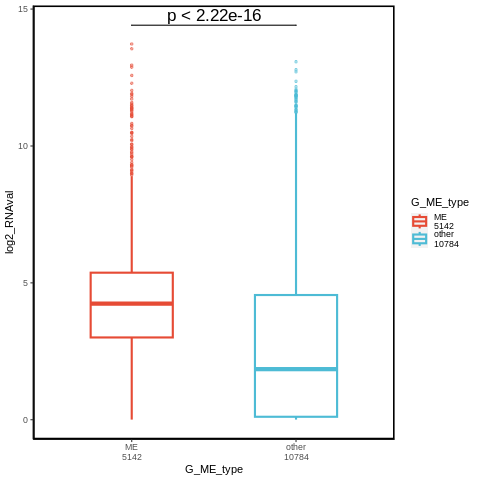

In [131]:
%%R -i G_ME_plot
p <- ggplot(G_ME_plot, aes(x = G_ME_type, y = G_log2,  fill = G_ME_type)) +   
  geom_boxplot(aes(color=G_ME_type),linewidth=1,fill=NA, width = 0.5, outlier.size=1, outlier.alpha=0.5) +
  labs(x = "G_ME_type", y = "log2_RNAval") +
  theme(panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(), 
          panel.border = element_rect(colour = "black", fill=NA, size=1.5),
          axis.line = element_line()) +
  geom_signif(
      comparisons = list(c("ME\n5142","other\n10784")), map_signif_level = F, 
      test = t.test,step_increase = 0.1, textsize = 6, color = "black",
      tip_length=0) +
  scale_color_npg() +
  scale_fill_npg()
p

Saving 6.67 x 6.67 in image


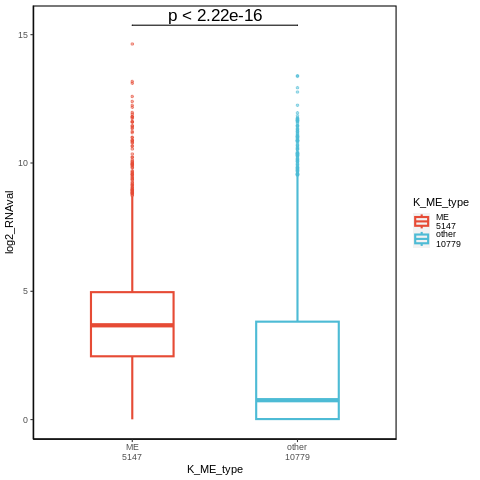

In [2736]:
%%R -i K_ME_plot
p <- ggplot(K_ME_plot, aes(x = K_ME_type, y = K_log2,  fill = K_ME_type)) +   
  geom_boxplot(aes(color=K_ME_type),linewidth=1,fill=NA, width = 0.5, outlier.size=1, outlier.alpha=0.5) +
  labs(x = "K_ME_type", y = "log2_RNAval") +
  theme(panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(), 
          panel.border = element_rect(colour = "black", fill=NA, size=1),
          axis.line = element_line()) +
  geom_signif(
      comparisons = list(c("ME\n5147","other\n10779")), map_signif_level = F, 
      test = t.test,step_increase = 0.1, textsize = 6, color = "black",
      tip_length=0) +
  scale_color_npg() +
  scale_fill_npg()
p

Saving 6.67 x 6.67 in image


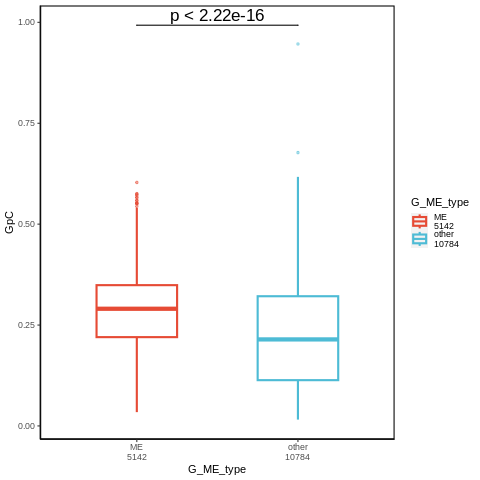

In [2737]:
%%R -i G_ME_plot
p <- ggplot(G_ME_plot, aes(x = G_ME_type, y = G_GCmean,  fill = G_ME_type)) +   
  geom_boxplot(aes(color=G_ME_type),linewidth=1,fill=NA, width = 0.5, outlier.size=1, outlier.alpha=0.5) +
  labs(x = "G_ME_type", y = "GpC") +
  theme(panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(), 
          panel.border = element_rect(colour = "black", fill=NA, size=1),
          axis.line = element_line()) +
  geom_signif(
      comparisons = list(c("ME\n5142","other\n10784")), map_signif_level = F, 
      test = t.test,step_increase = 0.1, textsize = 6, color = "black",
      tip_length=0) +
  scale_color_npg() +
  scale_fill_npg()
p

Saving 6.67 x 6.67 in image


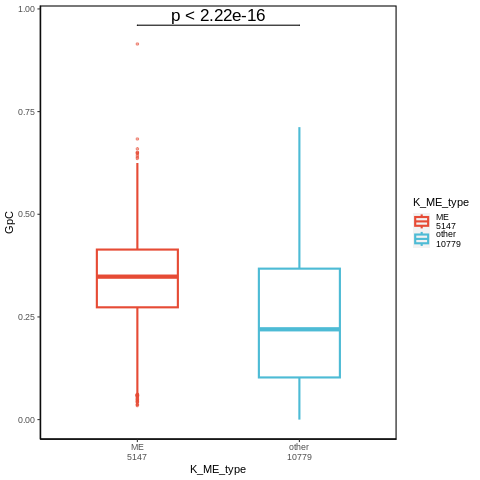

In [2738]:
%%R -i K_ME_plot
p <- ggplot(K_ME_plot, aes(x = K_ME_type, y = K_GCmean,  fill = K_ME_type)) +   
  geom_boxplot(aes(color=K_ME_type),linewidth=1,fill=NA, width = 0.5, outlier.size=1, outlier.alpha=0.5) +
  labs(x = "K_ME_type", y = "GpC") +
  theme(panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(), 
          panel.border = element_rect(colour = "black", fill=NA, size=1),
          axis.line = element_line()) +
  geom_signif(
      comparisons = list(c("ME\n5147","other\n10779")), map_signif_level = F, 
      test = t.test,step_increase = 0.1, textsize = 6, color = "black",
      tip_length=0) +
  scale_color_npg() +
  scale_fill_npg()
p

Saving 6.67 x 6.67 in image


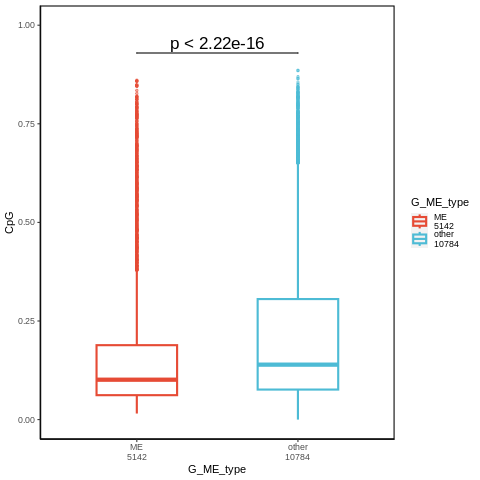

In [91]:
%%R -i G_ME_plot
p <- ggplot(G_ME_plot, aes(x = G_ME_type, y = G_CGmean,  fill = G_ME_type)) +   
  geom_boxplot(aes(color=G_ME_type),linewidth=1,fill=NA, width = 0.5, outlier.size=1, outlier.alpha=0.5) +
  labs(x = "G_ME_type", y = "CpG") +
  theme(panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(), 
          panel.border = element_rect(colour = "black", fill=NA, size=1),
          axis.line = element_line()) +
  geom_signif(
      comparisons = list(c("ME\n5142","other\n10784")), map_signif_level = F, 
      test = t.test,step_increase = 0.1, textsize = 6, color = "black",
      tip_length=0) +
  scale_color_npg() +
  scale_fill_npg() +
  scale_y_continuous(limits = c(0, 1))
p

Saving 6.67 x 6.67 in image


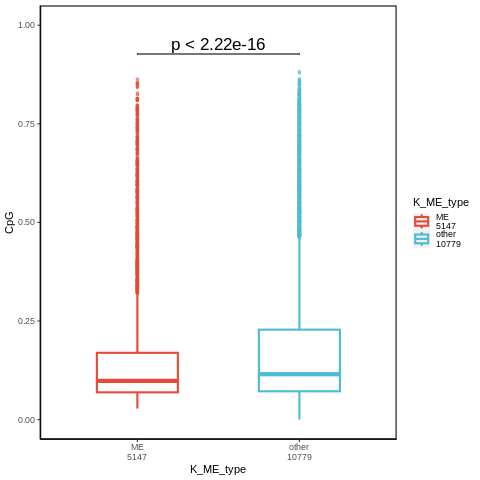

In [92]:
%%R -i K_ME_plot
p <- ggplot(K_ME_plot, aes(x = K_ME_type, y = K_CGmean,  fill = K_ME_type)) +   
  geom_boxplot(aes(color=K_ME_type),linewidth=1,fill=NA, width = 0.5, outlier.size=1, outlier.alpha=0.5) +
  labs(x = "K_ME_type", y = "CpG") +
  theme(panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(), 
          panel.border = element_rect(colour = "black", fill=NA, size=1),
          axis.line = element_line()) +
  geom_signif(
      comparisons = list(c("ME\n5147","other\n10779")), map_signif_level = F, 
      test = t.test,step_increase = 0.1, textsize = 6, color = "black",
      tip_length=0) +
  scale_color_npg() +
  scale_fill_npg() +
  scale_y_continuous(limits = c(0, 1))
p

In [97]:
def proportion(df, type_col, ME_col, type_list):
    OUT_dict1 = {}
    OUT_dict2 = {}
    all_ME = len(df.loc[df[ME_col]!=0])
    all_other = len(df.loc[df[ME_col]==0])
    g1 = PIVOT_DF.loc[PIVOT_DF[type_col]==type_list[0]]
    g2 = PIVOT_DF.loc[PIVOT_DF[type_col]==type_list[1]]
    g3 = PIVOT_DF.loc[PIVOT_DF[type_col]==type_list[2]]
    g4 = PIVOT_DF.loc[PIVOT_DF[type_col]==type_list[3]]

    OUT_dict1[type_list[0]] = len(g1.loc[g1[ME_col]!=0]) / all_ME
    OUT_dict1[type_list[1]] = len(g2.loc[g2[ME_col]!=0]) / all_ME
    OUT_dict1[type_list[2]] = len(g3.loc[g3[ME_col]!=0]) / all_ME
    OUT_dict1[type_list[3]] = len(g4.loc[g4[ME_col]!=0]) / all_ME

    OUT_dict2[type_list[0]] = len(g1.loc[g1[ME_col]==0]) / all_other
    OUT_dict2[type_list[1]] = len(g2.loc[g2[ME_col]==0]) / all_other
    OUT_dict2[type_list[2]] = len(g3.loc[g3[ME_col]==0]) / all_other
    OUT_dict2[type_list[3]] = len(g4.loc[g4[ME_col]==0]) / all_other
    
    OUT_DF1 = pd.DataFrame.from_dict(OUT_dict1, orient='index').reset_index()
    OUT_DF2 = pd.DataFrame.from_dict(OUT_dict2, orient='index').reset_index()
    OUT_DF1.columns=['type', 'ME_proportion']
    OUT_DF2.columns=['type', 'ME_proportion']
    OUT_DF1['tag'] = 'ME'
    OUT_DF2['tag'] = 'other'
    OUT_DF=pd.concat([OUT_DF1, OUT_DF2])
    return OUT_DF

In [98]:
G_proportion_df = proportion(PIVOT_DF, "G_express_type", "G_ME_rat", PIVOT_DF['G_express_type'].value_counts().index)
K_proportion_df = proportion(PIVOT_DF, "K_express_type", "K_ME_rat", PIVOT_DF['K_express_type'].value_counts().index)

Saving 6.67 x 6.67 in image


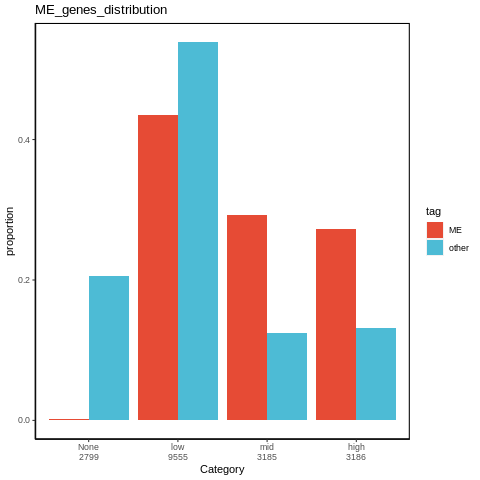

In [140]:
%%R -i G_proportion_df
G_proportion_df$type <- factor(G_proportion_df$type, levels = c("None\n2799", "low\n9555", "mid\n3185", "high\n3186"))
p<-ggplot(data = G_proportion_df, aes(x = type, y = ME_proportion, fill=tag)) +
  geom_bar(stat = "identity", position=position_dodge(0.9)) +
  labs(title = "ME_genes_distribution", x = "Category", y = "proportion")+
    theme(panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(), 
          panel.border = element_rect(colour = "black", fill=NA, size=1),
          axis.line = element_line())+
  scale_color_npg() +
  scale_fill_npg()
p

Saving 6.67 x 6.67 in image


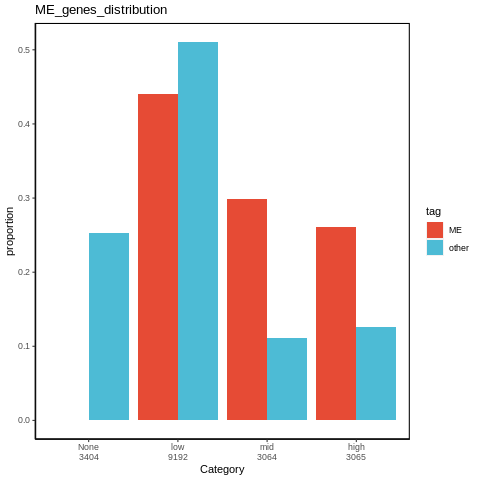

In [141]:
%%R -i K_proportion_df
K_proportion_df$type <- factor(K_proportion_df$type, levels = c("None\n3404", "low\n9192", "mid\n3064", "high\n3065"))
p<-ggplot(data = K_proportion_df, aes(x = type, y = ME_proportion, fill=tag)) +
  geom_bar(stat = "identity", position=position_dodge(0.9)) +
  labs(title = "ME_genes_distribution", x = "Category", y = "proportion")+
    theme(panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(), 
          panel.border = element_rect(colour = "black", fill=NA, size=1),
          axis.line = element_line())+
  scale_color_npg() +
  scale_fill_npg()
p

In [104]:
G_UP_GENE = ME_express_df.loc[ME_express_df['G_type']=='up', 'gene'].tolist()
G_DOWN_GENE = ME_express_df.loc[ME_express_df['G_type']=='down', 'gene'].tolist()

In [105]:
ALL_diff = pd.read_table("~/All_diffsig.txt",)
ALL_diff = ALL_diff.reset_index()[['index', 'logFC', 'P.Value']]
G_UP_compare_df = PIVOT_DF.loc[PIVOT_DF['gene'].isin(G_UP_GENE)].copy()
G_DOWN_compare_df = PIVOT_DF.loc[PIVOT_DF['gene'].isin(G_DOWN_GENE)].copy()

G_UP_compare_df = pd.merge(G_UP_compare_df, ALL_diff,
                           left_on='gene', right_on='index')
G_DOWN_compare_df = pd.merge(G_DOWN_compare_df, ALL_diff,
                             left_on='gene', right_on='index')

In [107]:
def min_max_normalize_series(series):
    return (series - series.min()) / (series.max() - series.min())
test = {
    'A': [1, 2, 3, 4, 5],
    'B': [5, 4, 3, 2, 1],
    'C': [10, 15, 20, 25, 30]
}
test_df = pd.DataFrame(test)

# 对每一列应用归一化
test_normalized_df = test_df.apply(min_max_normalize_series)

print(test_normalized_df)

      A     B     C
0  0.00  1.00  0.00
1  0.25  0.75  0.25
2  0.50  0.50  0.50
3  0.75  0.25  0.75
4  1.00  0.00  1.00


In [112]:
GUPBED = G_UP_compare_df[['chr', 'start', 'end', 'gene', 'strand']].copy()
GDOWNBED = G_DOWN_compare_df[['chr', 'start', 'end', 'gene', 'strand']].copy()
GUPBED['score'] = 0
GDOWNBED['score'] = 0
GUPBED = GUPBED[['chr', 'start', 'end', 'gene', 'score', 'strand']]
GDOWNBED = GDOWNBED[['chr', 'start', 'end', 'gene', 'score', 'strand']]

In [113]:
OUT_diff_up = G_UP_compare_df[['chr', 'start', 'end', 'gene', 'strand']].copy()
OUT_diff_down = G_DOWN_compare_df[['chr', 'start', 'end', 'gene', 'strand']].copy()

In [114]:
OUT_diff_up['score'] = 0
OUT_diff_up = OUT_diff_up[['chr', 'start', 'end', 'gene', 'score', 'strand']]
OUT_diff_down['score'] = 0
OUT_diff_down = OUT_diff_down[['chr', 'start', 'end', 'gene', 'score', 'strand']]

In [115]:
G_UP_GENES = OUT_diff_up['gene'].tolist()
G_DOWN_GENES = OUT_diff_down['gene'].tolist()

In [116]:
K_enh_target_df = pd.read_table("~/K562.enh_38_sorted.txt",
                                header=None)

In [118]:
G_UP_GEnh_df = enh_target_df.loc[enh_target_df[3].isin(G_UP_GENES)]
G_DOWN_GEnh_df = enh_target_df.loc[enh_target_df[3].isin(G_DOWN_GENES)]

G_UP_KEnh_df = K_enh_target_df.loc[K_enh_target_df[3].isin(G_UP_GENES)]
G_DOWN_KEnh_df = K_enh_target_df.loc[K_enh_target_df[3].isin(G_DOWN_GENES)]

In [119]:
# 提取 G_up 和 G_down 区域中的基本指标：GC/CpG 比例 和 甲基化比例
basic_up = G_UP_compare_df[['G_GCmean', 'K_GCmean', 'G_CGmean', 'K_CGmean', 'G_ME_rat', 'K_ME_rat']].copy()
basic_down = G_DOWN_compare_df[['G_GCmean', 'K_GCmean', 'G_CGmean', 'K_CGmean', 'G_ME_rat', 'K_ME_rat']].copy()

# 分别提取 G/K 样本中上调区域的 GC 平均值
Gbasic_up_GC = basic_up[['G_GCmean']].copy()
Kbasic_up_GC = basic_up[['K_GCmean']].copy()

# 提取 CpG 平均值
Gbasic_up_CG = basic_up[['G_CGmean']].copy()
Kbasic_up_CG = basic_up[['K_CGmean']].copy()

# 提取甲基化比例
Gbasic_up_ME = basic_up[['G_ME_rat']].copy()
Kbasic_up_ME = basic_up[['K_ME_rat']].copy()

# 同样的处理用于下调区域
Gbasic_down_GC = basic_down[['G_GCmean']].copy()
Kbasic_down_GC = basic_down[['K_GCmean']].copy()

Gbasic_down_CG = basic_down[['G_CGmean']].copy()
Kbasic_down_CG = basic_down[['K_CGmean']].copy()

Gbasic_down_ME = basic_down[['G_ME_rat']].copy()
Kbasic_down_ME = basic_down[['K_ME_rat']].copy()

# 为上调区域添加分组标签（标签可用于后续 ggplot 分组比较）
Gbasic_up_GC['tag'] = 'G_up_420'
Kbasic_up_GC['tag'] = 'K_down_420'

Gbasic_up_CG['tag'] = 'G_up_420'
Kbasic_up_CG['tag'] = 'K_down_420'

Gbasic_up_ME['tag'] = 'G_up_420'
Kbasic_up_ME['tag'] = 'K_down_420'

# 为下调区域添加分组标签
Gbasic_down_GC['tag'] = 'G_down_128'
Kbasic_down_GC['tag'] = 'K_up_128'

Gbasic_down_CG['tag'] = 'G_down_128'
Kbasic_down_CG['tag'] = 'K_up_128'

Gbasic_down_ME['tag'] = 'G_down_128'
Kbasic_down_ME['tag'] = 'K_up_128'

# 重命名列统一为 'value' 和 'tag'，方便合并后绘图使用
Gbasic_up_GC.columns = ['value', 'tag']
Kbasic_up_GC.columns = ['value', 'tag']
Gbasic_up_CG.columns = ['value', 'tag']
Kbasic_up_CG.columns = ['value', 'tag']
Gbasic_up_ME.columns = ['value', 'tag']
Kbasic_up_ME.columns = ['value', 'tag']

# 合并上调区域 GC/CpG/ME 数据（G 与 K 样本），并重置索引
diff_GC = pd.concat([Gbasic_up_GC, Kbasic_up_GC]).reset_index(drop=True).fillna(0)
diff_CG = pd.concat([Gbasic_up_CG, Kbasic_up_CG]).reset_index(drop=True).fillna(0)
diff_ME = pd.concat([Gbasic_up_ME, Kbasic_up_ME]).reset_index(drop=True).fillna(0)

# 重命名下调区域列
Gbasic_down_GC.columns = ['value', 'tag']
Kbasic_down_GC.columns = ['value', 'tag']
Gbasic_down_CG.columns = ['value', 'tag']
Kbasic_down_CG.columns = ['value', 'tag']
Gbasic_down_ME.columns = ['value', 'tag']
Kbasic_down_ME.columns = ['value', 'tag']

# 合并下调区域数据（未使用 fillna，保留缺失信息用于判断）
K_diff_GC = pd.concat([Gbasic_down_GC, Kbasic_down_GC]).reset_index(drop=True)
K_diff_CG = pd.concat([Gbasic_down_CG, Kbasic_down_CG]).reset_index(drop=True)
K_diff_ME = pd.concat([Gbasic_down_ME, Kbasic_down_ME]).reset_index(drop=True)

Saving 6.67 x 6.67 in image


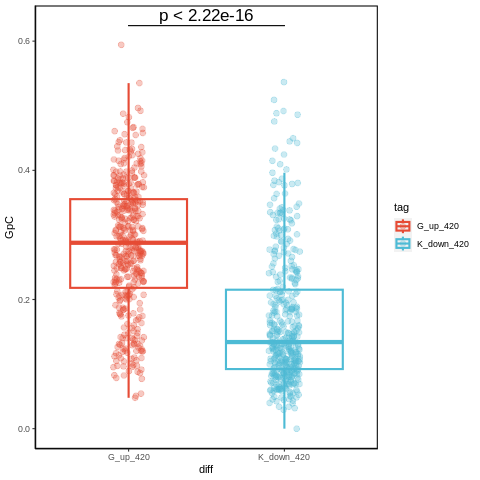

In [2701]:
%%R -i diff_GC
library(dplyr)
library(ggplot2)
library(ggsci)
colors <- c("#E64B35FF", "#4DBBD5FF")
p <- ggplot(diff_GC, aes(x = tag, y = value,  fill = tag)) +   
  geom_boxplot(aes(color=tag),linewidth=1,fill=NA, outlier.shape = NA) +
  labs(x = "diff", y = "GpC") +
  # theme_minimal() +
  geom_signif(
      comparisons = list(c("G_up_420","K_down_420")), map_signif_level = F, 
      test = t.test,step_increase = 0.1, textsize = 6, color = "black",
      tip_length=0) +
  geom_jitter(aes(color=factor(tag)),size=2.5,width=0.1,alpha=0.3) +
  theme(panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(), 
          panel.border = element_rect(colour = "black", fill=NA, size=1),
          axis.line = element_line()) +
  scale_color_npg() 
p

Saving 6.67 x 6.67 in image


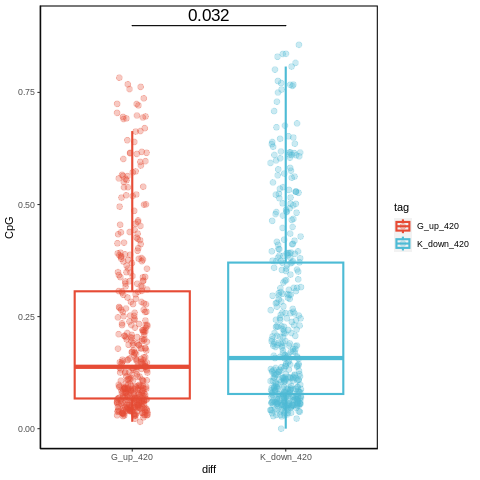

In [2703]:
%%R -i diff_CG
library(dplyr)
library(ggplot2)
library(ggsci)
colors <- c("#E64B35FF", "#4DBBD5FF")
p <- ggplot(diff_CG, aes(x = tag, y = value,  fill = tag)) +   
  geom_boxplot(aes(color=tag),linewidth=1,fill=NA, outlier.shape = NA) +
  labs(x = "diff", y = "CpG") +
  # theme_minimal() +
  geom_signif(
      comparisons = list(c("G_up_420","K_down_420")), map_signif_level = F, 
      test = t.test,step_increase = 0.1, textsize = 6, color = "black",
      tip_length=0) +
  geom_jitter(aes(color=factor(tag)),size=2.5,width=0.1,alpha=0.3) +
  theme(panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(), 
          panel.border = element_rect(colour = "black", fill=NA, size=1),
          axis.line = element_line()) +
  scale_color_npg() 
p

Saving 6.67 x 6.67 in image


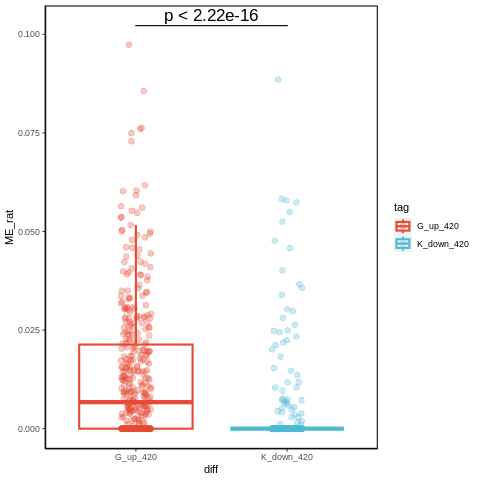

In [2705]:
%%R -i diff_ME
library(dplyr)
library(ggplot2)
library(ggsci)
colors <- c("#E64B35FF", "#4DBBD5FF")
p <- ggplot(diff_ME, aes(x = tag, y = value,  fill = tag)) +   
  geom_boxplot(aes(color=tag),linewidth=1,fill=NA, outlier.shape = NA) +
  labs(x = "diff", y = "ME_rat") +
  # theme_minimal() +
  geom_signif(
      comparisons = list(c("G_up_420","K_down_420")), map_signif_level = F, 
      test = t.test,step_increase = 0.1, textsize = 6, color = "black",
      tip_length=0) +
  geom_jitter(aes(color=factor(tag)),size=2.5,width=0.1,alpha=0.3) +
  theme(panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(), 
          panel.border = element_rect(colour = "black", fill=NA, size=1),
          axis.line = element_line()) +
  scale_color_npg()
p

Saving 6.67 x 6.67 in image


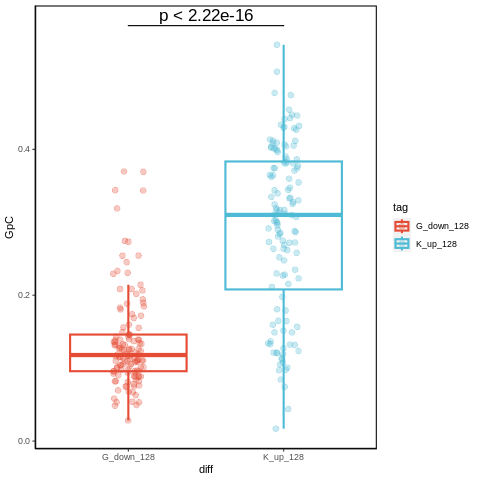

In [2709]:
%%R -i K_diff_GC
library(dplyr)
library(ggplot2)
library(ggsci)
colors <- c("#E64B35FF", "#4DBBD5FF")
p <- ggplot(K_diff_GC, aes(x = tag, y = value,  fill = tag)) +   
  geom_boxplot(aes(color=tag),linewidth=1,fill=NA, outlier.shape = NA) +
  labs(x = "diff", y = "GpC") +
  # theme_minimal() +
  geom_signif(
      comparisons = list(c("G_down_128","K_up_128")), map_signif_level = F, 
      test = t.test,step_increase = 0.1, textsize = 6, color = "black",
      tip_length=0) +
  geom_jitter(aes(color=factor(tag)),size=2.5,width=0.1,alpha=0.3) +
  theme(panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(), 
          panel.border = element_rect(colour = "black", fill=NA, size=1),
          axis.line = element_line()) +
  scale_color_npg()
p

Saving 6.67 x 6.67 in image


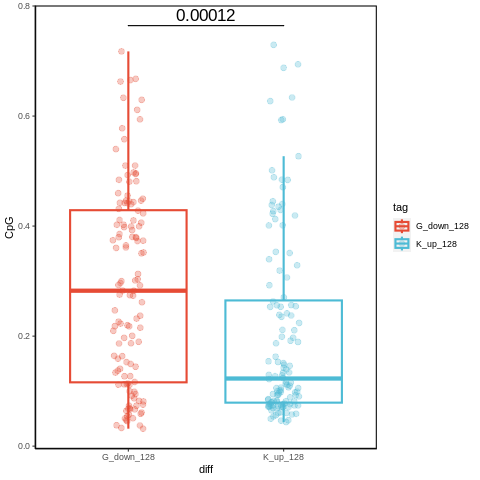

In [2712]:
%%R -i K_diff_CG
library(dplyr)
library(ggplot2)
library(ggsci)
colors <- c("#E64B35FF", "#4DBBD5FF")
p <- ggplot(K_diff_CG, aes(x = tag, y = value,  fill = tag)) +   
  geom_boxplot(aes(color=tag),linewidth=1,fill=NA, outlier.shape = NA) +
  labs(x = "diff", y = "CpG") +
  # theme_minimal() +
  geom_signif(
      comparisons = list(c("G_down_128","K_up_128")), map_signif_level = F, 
      test = t.test,step_increase = 0.1, textsize = 6, color = "black",
      tip_length=0) +
  geom_jitter(aes(color=factor(tag)),size=2.5,width=0.1,alpha=0.3) +
  theme(panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(), 
          panel.border = element_rect(colour = "black", fill=NA, size=1),
          axis.line = element_line()) +
  scale_color_npg()
p

Saving 6.67 x 6.67 in image


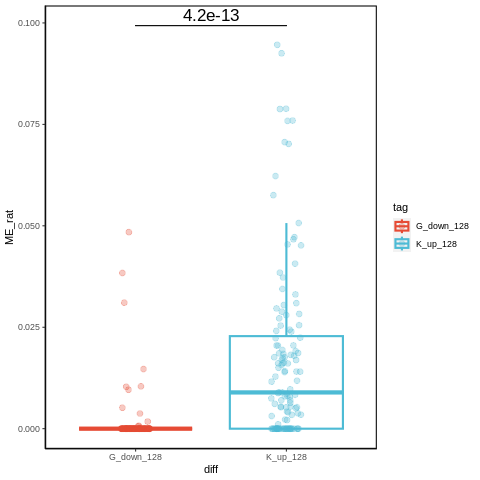

In [2713]:
%%R -i K_diff_ME
library(dplyr)
library(ggplot2)
library(ggsci)
colors <- c("#E64B35FF", "#4DBBD5FF")
p <- ggplot(K_diff_ME, aes(x = tag, y = value,  fill = tag)) +   
  geom_boxplot(aes(color=tag),linewidth=1,fill=NA, outlier.shape = NA) +
  labs(x = "diff", y = "ME_rat") +
  # theme_minimal() +
  geom_signif(
      comparisons = list(c("G_down_128","K_up_128")), map_signif_level = F, 
      test = t.test,step_increase = 0.1, textsize = 6, color = "black",
      tip_length=0) +
  geom_jitter(aes(color=factor(tag)),size=2.5,width=0.1,alpha=0.3) +
  theme(panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(), 
          panel.border = element_rect(colour = "black", fill=NA, size=1),
          axis.line = element_line()) +
  scale_color_npg()
p